# Words in a Time of Crisis: Analyzing Sixth Tone's Reportage on COVID-19 in China

Meihan Luo  
meihan.luo@student.kuleuven.be  

14.01.2024

### Overview:  
[Sixth Tone](https://www.sixthtone.com/) is an English-language news outlet focusing on covering China by telling stories of normal people. This project first collects Sixth Tone's COVID-related news reports from 2020 to 2022, and then analyzes how Sixth Tone covered the pandemic in China through a blend of descriptive statistics, text analysis, trend analysis, sentiment assessments, and topic modeling.  
The project delves into the frequency and length of the articles, dissects the prominence of certain words within headlines and main content, and contextualizes the usage of specific terms. Additionally, it charts the evolution of reporting volume, sentiment, and dominant topics throughout the pandemic, which could reflect the pandemic's evolving phases. Furthermore, it explores correlations among various characteristics of news reports discussed above, such as visualizing the relationship between the length of articles and their neutral sentiment across the primary topics covered.

# 1. Data collection

After inspecting Sixth Tone's [coronavirus topic page](https://www.sixthtone.com/topics/1005117/Coronavirus), I extracted URLs for all COVID-related reports published between 2020 and 2022 by making requests to the site's API across 33 pages.

In [1]:
import requests
from bs4 import BeautifulSoup
import json
from datetime import datetime

# Find the request URL under the "Network" tab within the developer tools
# after scrolling down to load more content on the website that triggers the network request
sixthtone_api = 'https://api.sixthtone.com/cont/topic/getByTopicId'

headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
}

content_ids = []

# Extract a list of content ids of all relevant articles
# The content is divided into 33 pages. Each page represents a separate set of results returned by the API.
for page_num in range(1, 34): 
    payload = {
        'topicId': "1005117", # specific topic ID "Coronavirus"
        'pageSize': 20,       # the number of results per page
        'pageNum': page_num   # the current page number
    }
    
    response = requests.post(sixthtone_api, headers=headers, json=payload)
    data = response.json()
    articles = data['data']['pageInfo']['list']

    for article in articles:
        # Skip non-standard entries like 'MOST READ'
        if 'pubTime' not in article or 'contId' not in article:
            continue

        pub_time = article['pubTime']
        pub_year = datetime.strptime(pub_time, "%b %d, %Y").year
        
        # Only extract articles published within 2020-2022
        if 2020 <= pub_year <= 2022:
            cont_id = article['contId']
            content_ids.append(cont_id)
    
# Generate a list of URLs for all articles based on content_ids
base_url = 'https://www.sixthtone.com/news/'
links = [base_url + str(content_id) for content_id in content_ids]
links

['https://www.sixthtone.com/news/1011990',
 'https://www.sixthtone.com/news/1011970',
 'https://www.sixthtone.com/news/1011945',
 'https://www.sixthtone.com/news/1011952',
 'https://www.sixthtone.com/news/1011953',
 'https://www.sixthtone.com/news/1011927',
 'https://www.sixthtone.com/news/1011925',
 'https://www.sixthtone.com/news/1011923',
 'https://www.sixthtone.com/news/1011924',
 'https://www.sixthtone.com/news/1011911',
 'https://www.sixthtone.com/news/1011910',
 'https://www.sixthtone.com/news/1011904',
 'https://www.sixthtone.com/news/1011903',
 'https://www.sixthtone.com/news/1011896',
 'https://www.sixthtone.com/news/1011888',
 'https://www.sixthtone.com/news/1011873',
 'https://www.sixthtone.com/news/1011845',
 'https://www.sixthtone.com/news/1011836',
 'https://www.sixthtone.com/news/1011824',
 'https://www.sixthtone.com/news/1011783',
 'https://www.sixthtone.com/news/1011749',
 'https://www.sixthtone.com/news/1011728',
 'https://www.sixthtone.com/news/1011715',
 'https://w

In [16]:
# Extract information (main title, subtitle, date, paragraphs) for each article
# and write them into a CSV file

import re
import csv

def parse_content(link):
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    return extract_info(soup, link)

def extract_info(soup, link):
    title = extract_text(soup, 'h3', 'index_title__qwh0k')
    subtitle = extract_text(soup, 'div', 'index_desc__7RwOS rrw')
    date_published = extract_date(soup)
    paragraphs = clean_paragraphs(soup.find_all('p'))
    return {
        'title': title,
        'subtitle': subtitle,
        'date_published': date_published,
        'text': paragraphs,
        'link': link
    }

def extract_text(soup, tag, class_name):
    element = soup.find(tag, class_=class_name)
    return element.get_text().strip() if element else '' # Skip non-standard entries without the elements

def extract_date(soup):
    date_container = soup.find('div', class_='index_time__fXJxh')
    # Safely extract date
    if date_container:
        date_text = date_container.find('span').get_text().strip()
        try:
            return datetime.strptime(date_text, "%b %d, %Y").strftime("%Y-%m-%d")
        except ValueError:
            return 'Unknown Date'
    return 'Unknown Date'

def clean_paragraphs(paragraphs):
    full_text = ' '.join(p.get_text().strip() for p in paragraphs)
    
    # Exclude irrelevant phrases
    pattern = re.compile(
        r'\b(Subscribe to our newsletter|FOLLOW US)\b|'
        r'(Additional reporting:|Editor:|Editors:|Reporters:|Producer:).*?(\.\s|\.$|$)|'
        r'\(Header image:.*?\)'
    )
    cleaned_text = pattern.sub('', full_text).strip()
    return cleaned_text
    
    
articles = [parse_content(link) for link in links if parse_content(link)]

# Export the result into a CSV file
with open("covid_reports.csv", 'w') as out_file:
    writer = csv.DictWriter(out_file, fieldnames=['title', 'subtitle', 'date_published', 'text', 'link'])
    writer.writeheader()
    for article in articles:
        writer.writerow(article)

# 2. Data preprocessing

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

df = pd.read_csv('covid_reports.csv')
df.shape

(592, 5)

In [161]:
# Add columns about dates to facilitate trend analysis
df['date_published'] = pd.to_datetime(df['date_published'])
df['year_month'] = df['date_published'].dt.to_period('M')
df['year'] = df['year_month'].dt.year
df['week_of_year'] = df['date_published'].dt.isocalendar().week
df.head()

title  \
0  As COVID Surges, Chinese Turn to Black Market ...   
1  China’s Inbound Travelers Confused Over Quaran...   
2  Staying Negative: New Covid Policies Bring Mem...   
3  Shanghai Races to Vaccinate Older Residents as...   
4  As Couriers Fall Sick, Chinese Cities Ask Resi...   

                                            subtitle date_published  \
0  Scalpers are reportedly selling Paxlovid for a...     2022-12-28   
1  Many returnees say they’re unsure about going ...     2022-12-23   
2  The Chinese internet has exploded with people ...     2022-12-23   
3  A district has started its fourth booster dose...     2022-12-21   
4  The delivery sector is facing an acute shortag...     2022-12-21   

                                                text  \
0  The lack of availability of a crucial COVID-19...   
1  Isabella Tang paid a hefty sum to return home ...   
2  Since China pivoted away from its “dynamic zer...   
3  SHANGHAI — Two days after Shanghai’s Jinshan D...   
4  Many Chinese cities are rallying local residen...   

                                     link year_month  year  week_of_year  
0  https://www.sixthtone.com/news/1011990    2022-12  2022            52  
1  https://www.sixthtone.com/news/1011970    2022-12  2022            51  
2  https://www.sixthtone.com/news/1011945    2022-12  2022            51  
3  https://www.sixthtone.com/news/1011952    2022-12  2022            51  
4  https://www.sixthtone.com/news/1011953    2022-12  2022            51

In [6]:
# Define functions for text preprocessing

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')

def clean_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase and remove stopwords
    tokens = [token.lower() for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatization with POS tagging
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
    
    return tokens
    
# Convert NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sixing/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 3. Data analysis and visualization

## 3.1 Distribution of Articles Counts and Word Counts
This setion first looks into the monthly distribution of COVID-related news reports, highlighting how the volume of reporting has fluctuated over time which potentially reflects the pandemic's evolving situations in China. Then, it delves into the distribution of article lengths in general as well as over time, examining the correlation between the quantity of reporting (indicated by the number of articles) and the depth of coverage (suggested by the average word count).

### Distribution of the number of reports per month over time

Text(0, 0.5, 'Number of Articles')

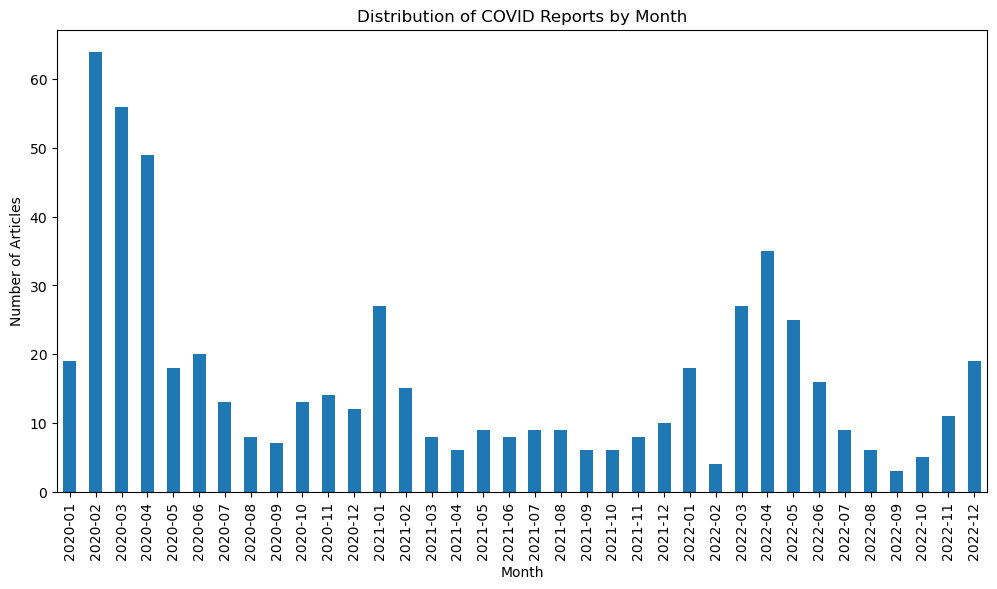

In [187]:
articles_per_month = df.groupby('year_month').size()

# Plotting
articles_per_month.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of COVID Reports by Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')

Analysis:  
- The result shows two notable spikes in coverage. The initial surge at the beginning of 2020 aligns with the emergence of the COVID-19 pandemic, and the subsequent spike from March to May 2022 coincides with a citywide lockdown in Shanghai amid new waves of infections. These key events triggered a high volume of media reporting to track the impact and response to the rapidly evolving situation.  
- The observed seasonality in reporting, particularly the pronounced uptick in January of both 2021 and 2022, aligns with the Chinese New Year period for family reunion. This annual migration often amplifies concerns related to COVID-19 due to increased travel, thereby attracting heightened media coverage during these months, followed by a subsequent decline.  
- Fluctuations in article frequency can reflect changes in COVID-related policies. For instance, the surge in reporting towards the close of 2022, a pattern not evident in the preceding years, came as China abandoned its zero-COVID policy.

### Distribution of word counts in general & over time

count     592.000000
mean      791.804054
std       613.540417
min        40.000000
25%       406.000000
50%       587.500000
75%      1004.750000
max      5435.000000
Name: word_count, dtype: float64

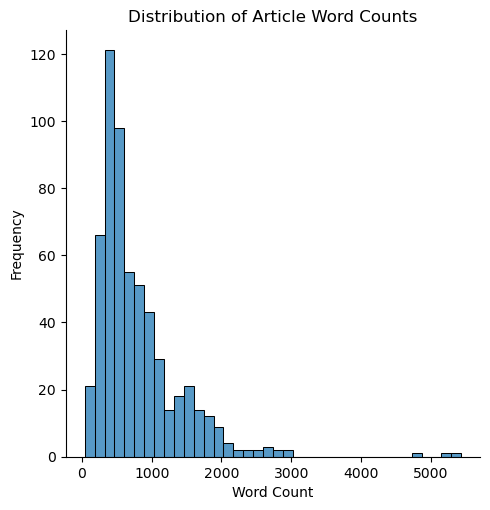

In [168]:
# Distribution of word counts in general
df['word_count'] = df['text'].apply(lambda text: len(text.split()))
word_count_data = df['word_count'].describe()

sns.displot(x='word_count', data=df)
plt.title('Distribution of Article Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

word_count_data

Analysis:  
- The majority of articles are shorter news pieces, typically fewer than 1,000 words, which aims to provide rapid updates on the COVID-19 situation.
- While short-form articles dominate, there remains a select collection of longer feature articles that delve into greater depth, offering comprehensive analyses and narratives of the pandemic's multifaceted impact.

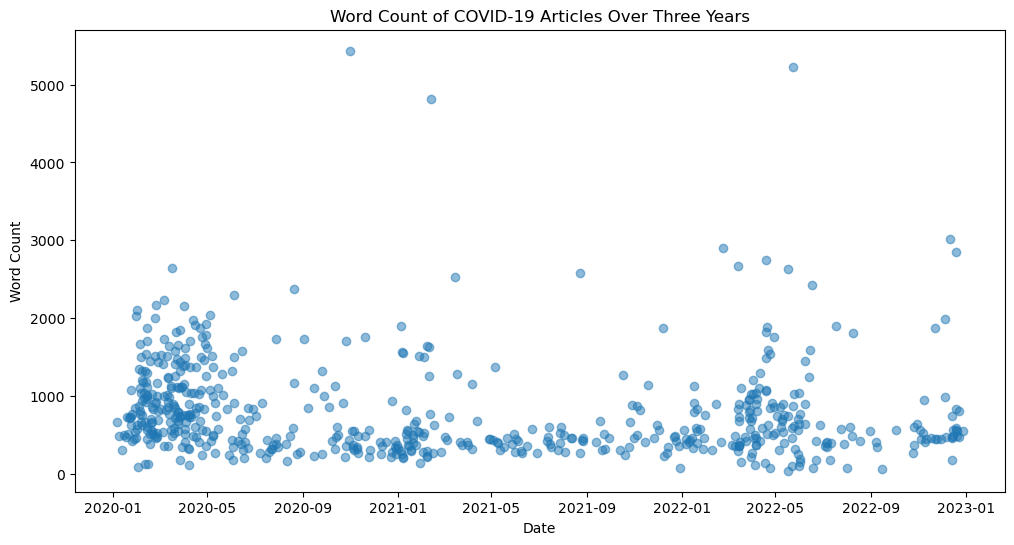

In [205]:
# Distribution of word counts over time
plt.figure(figsize=(12, 6))
plt.scatter(df['date_published'], df['word_count'], alpha=0.5)

plt.title('Word Count of COVID-19 Articles Over Three Years')
plt.xlabel('Date')
plt.ylabel('Word Count')
plt.show()

Analysis:  
- The distribution of word counts over time again shows shorter articles are more common than longer ones. Still, there are occasional instances of longer, more detailed reporting.  
- Notably, the incidence of these longer pieces appears to coincide with periods of intensified coverage, such as the early months of 2020 and from March to May in 2022. To testify the observation, the following analysis explores the correlation between reporting frequency and the length of articles.

### Correlation between the monthly reporting volume and average article length

Correlation coefficient: 0.5087536145892302


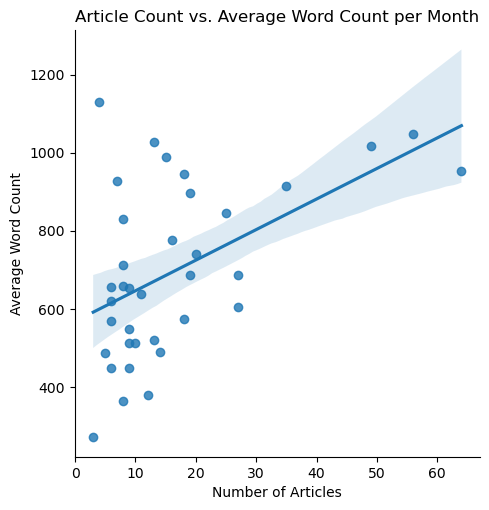

In [49]:
# Calculate the average word count of articles per month
avg_word_count_per_month = df.groupby('year_month')['word_count'].mean()

# Concatenate the number of articles published each month and their average word count
monthly_df = pd.concat([articles_per_month, avg_word_count_per_month], axis=1)
monthly_df.columns = ['articles_per_month', 'avg_word_count_per_month']

# Calculate the correlation coefficient
corr_coef = monthly_df['articles_per_month'].corr(monthly_df['avg_word_count_per_month'])
print(f"Correlation coefficient: {corr_coef}")

# Plotting
sns.lmplot(x='articles_per_month', y='avg_word_count_per_month', data=monthly_df)
plt.title('Article Count vs. Average Word Count per Month')
plt.xlabel('Number of Articles')
plt.ylabel('Average Word Count')
plt.show()

Analysis:  
- There is a positive relationship between the volume of articles and their length, which means as the number of articles increases, the average length of the articles tends to increase as well. This could imply that during periods of higher news output, articles are not only more frequent but also more detailed and in-depth.  
- The correlation coefficient value of 0.51 is moderate, suggesting that while there is a relationship, it is not exceptionally strong.

## 3.2 Text Analysis
This part first generates word clouds to identify the most common words and phrases within the titles, subtitles, and main text of the reports. Then, it examines the use of significant terms, such as "lockdown," by looking into the concordance, analyzing words of similar context, exploring common contexts of words, and observing collocations, in order to understand how certain topics are discussed in the corpus of COVID-19 related reports.

### Main titles

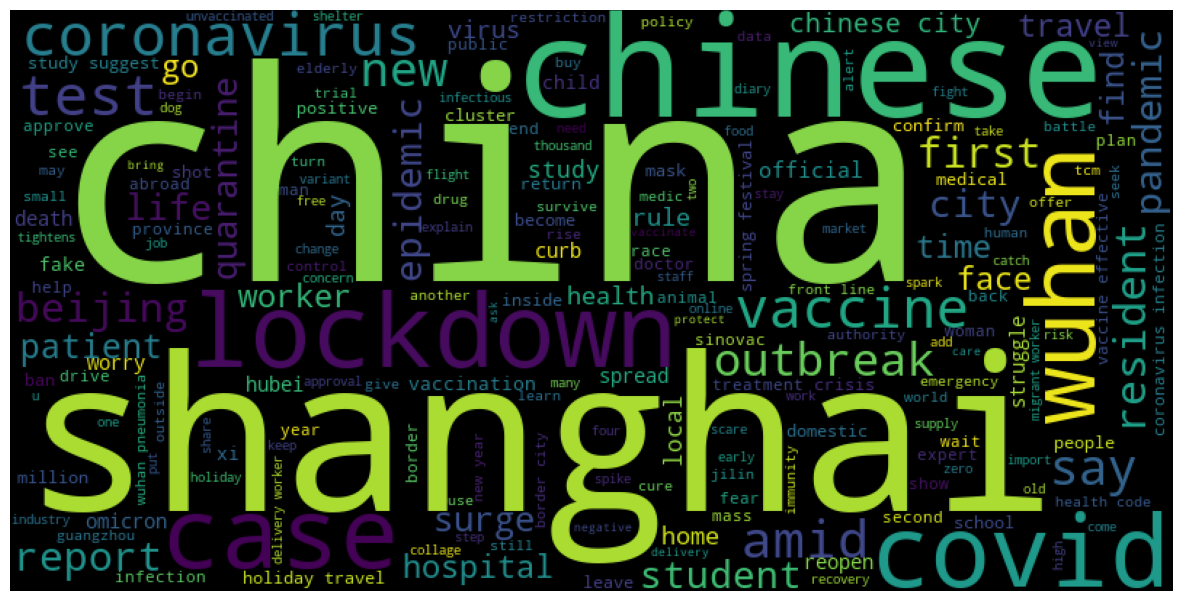

In [69]:
# Word cloud of main titles

# Preprocess titles
title_text = ' '.join(df['title'].dropna())
title_tokens = clean_text(title_text)

# Join tokens as a string for generating wordcloud
title_text = ' '.join(title_tokens)

wordcloud = WordCloud(width=800, height=400).generate(title_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

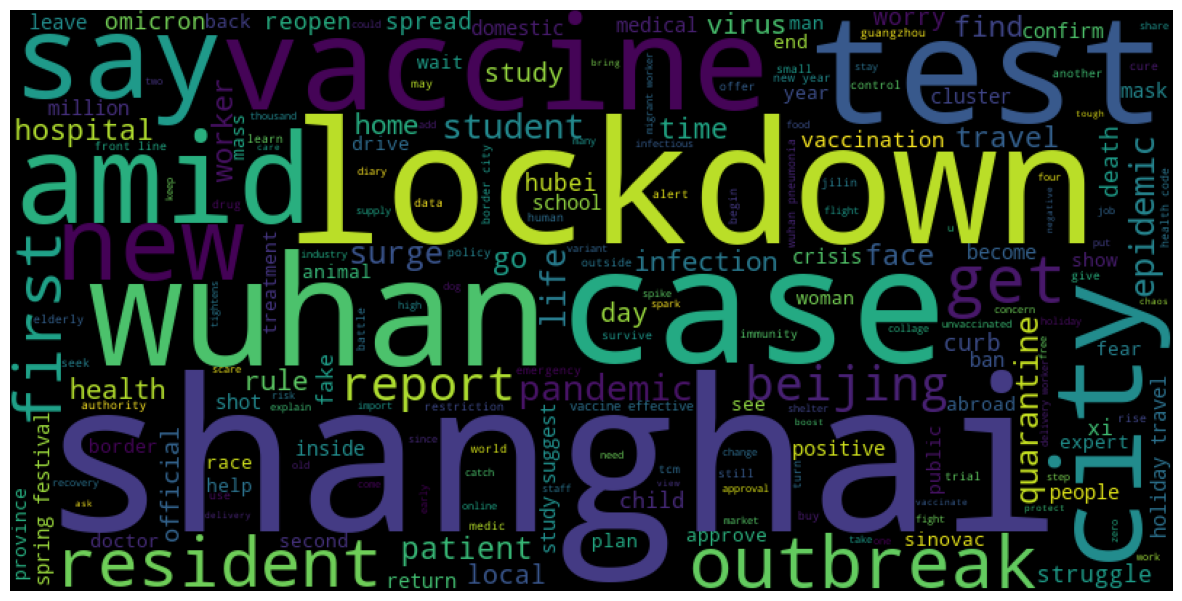

In [70]:
# Remove words that are expected to occur with high frequency in the context of the dataset
# and are not informative about the unique content of individual articles
extra_stopwords = set(['coronavirus', 'covid', 'china', 'chinese'])

wordcloud = WordCloud(width=800, height=400, stopwords=extra_stopwords).generate(title_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Analysis:  
- Main themes of reporting are visually apparent. Words like "lockdown," "test," "vaccine," and "outbreak" suggest that much of media reporting has focused on virus control measures, vaccination campaigns, and the tracking of COVID-19 outbreaks.  
- The geographical dimension is also prominent, with "Wuhan" and "Shanghai" frequently mentioned. Wuhan's significance stems from its role as the epicenter of the initial outbreak, while Shanghai's emphasis relates to the stringent lockdown measures implemented two years into the pandemic. 

### Subtitles

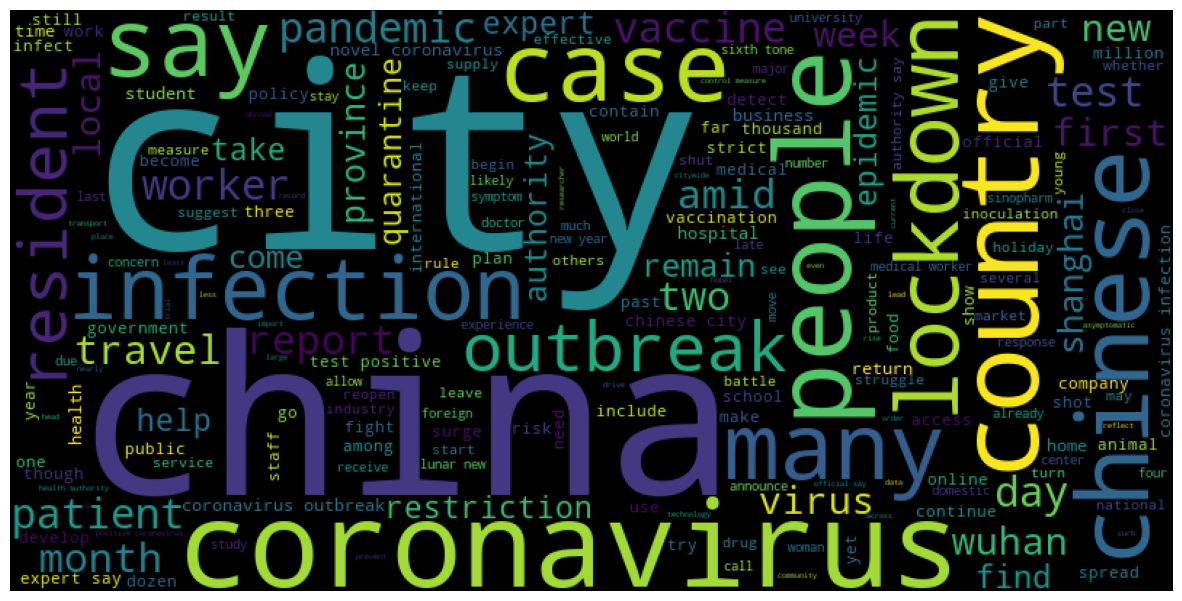

In [71]:
# Word cloud of subtitles

# Preprocess subtitles
subtitle_text = ' '.join(df['subtitle'].dropna())
subtitle_tokens = clean_text(subtitle_text)

# Join tokens as a string for generating wordcloud
subtitle_text = ' '.join(subtitle_tokens)

wordcloud = WordCloud(width=800, height=400).generate(subtitle_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

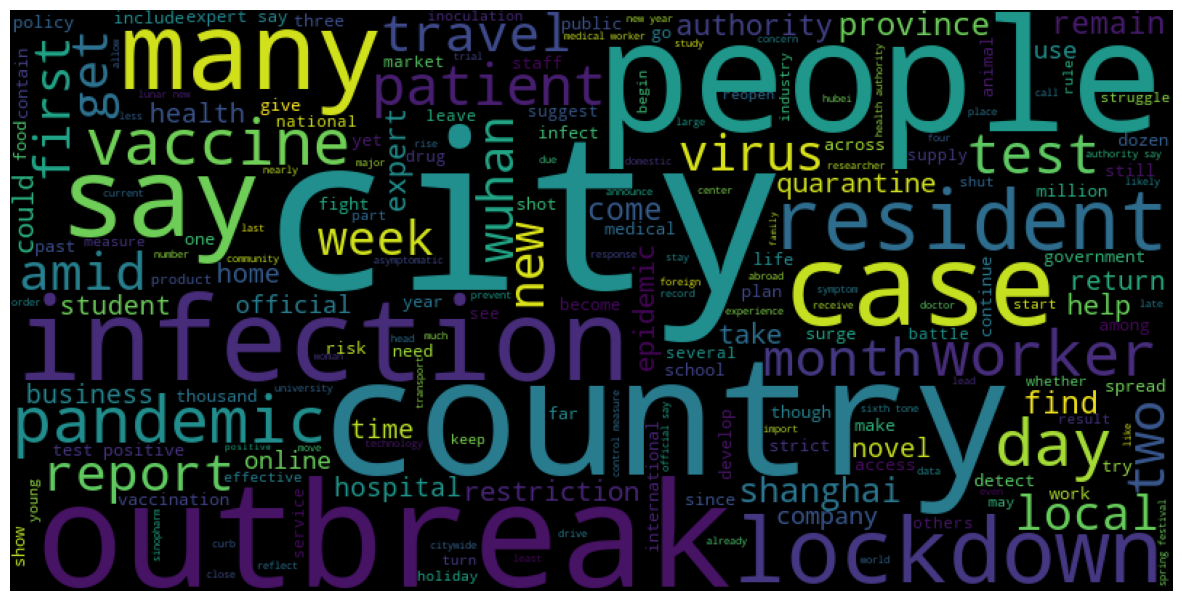

In [73]:
# Remove certain subject words
wordcloud = WordCloud(width=800, height=400, stopwords=extra_stopwords).generate(subtitle_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Analysis:  
- Words like "people," "resident," "worker," and "patient" are prominent in the subtitles, suggesting a human-centric narrative around the impact of the pandemic on individuals and communities.
- Terms such as "many," "travel," and "business" highlight the socioeconomic impact of the pandemic and provide more specific information.  
- Subtitles offer a more human-centered narrative and provide additional layers of detail, whereas the main titles use more general terms reflecting broader topics to encapsulate the essence of the articles.

### Body text (paragraphs)

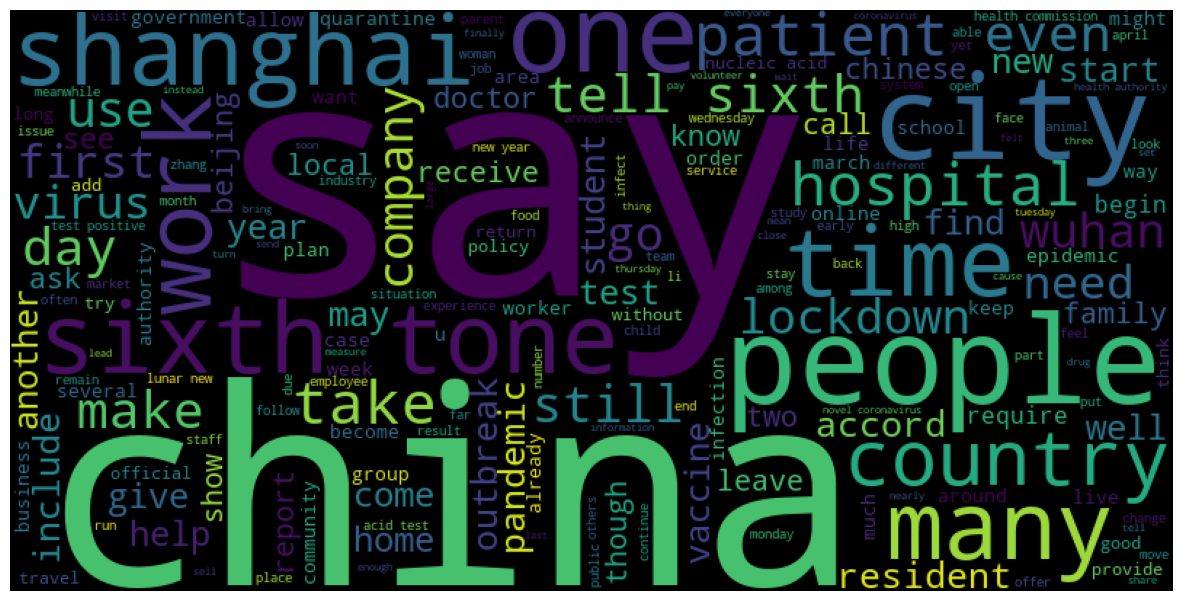

In [206]:
# Word cloud of body text

# Preprocess paragraphs
body_text = ' '.join(df['text'].dropna())
body_tokens = clean_text(body_text)

# Join tokens as a string for generating wordcloud
body_text = ' '.join(body_tokens)

wordcloud = WordCloud(width=800, height=400).generate(body_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

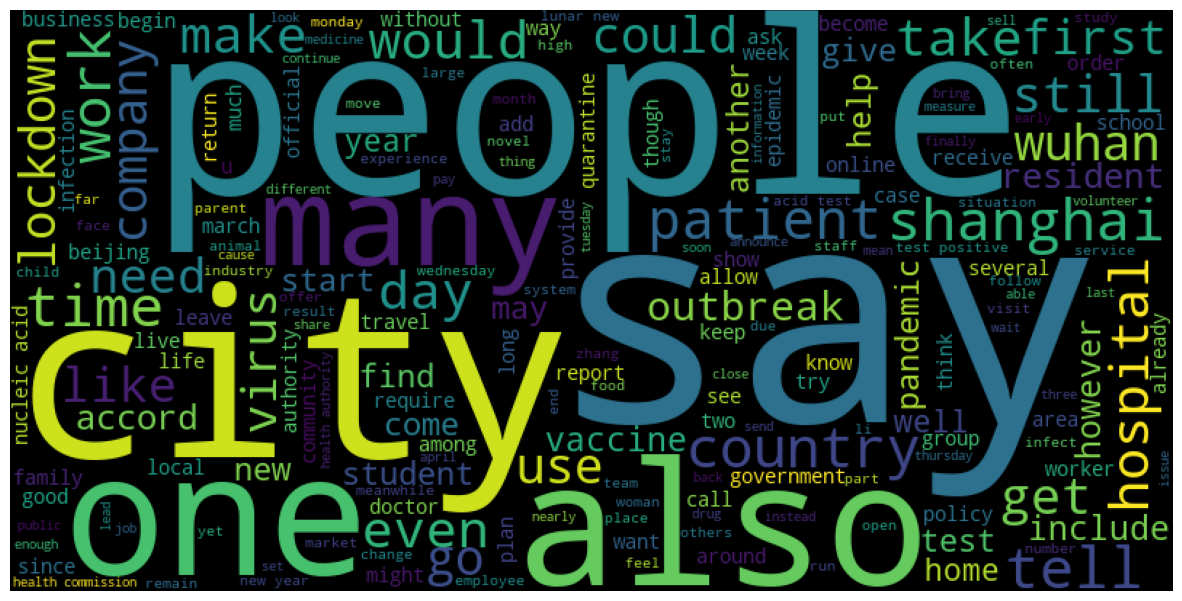

In [76]:
# Remove certain subject words
extra_stopwords = set(['coronavirus', 'covid', 'china', 'chinese', 'sixth', 'tone'])

wordcloud = WordCloud(width=800, height=400, stopwords=extra_stopwords).generate(body_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Analysis:  
- Human impact and response: Similar to subtitles, prominent words like "people" and "many" highlight the human aspect of the pandemic narrative, focusing on those affected and their experiences.
- The word "say" reflects that news reports heavily depend on a wide variety of interviews and first-hand accounts.

In [77]:
# Concordance of term "lockdown"
from nltk.text import Text

body_text_nltk = Text(body_tokens)
body_text_nltk.concordance("lockdown")

Displaying 25 of 729 matches:
 relaxation rule include mass test lockdown without much preparation bring lif
e vegetable tuncai case unexpected lockdown however infection seem inevitable 
ift gear much store vegetable wait lockdown stockpile medicine wait overnight 
on announce china would pivot away lockdown infect mild symptom could isolate 
y phone full message say guangzhou lockdown lift test longer need travel withi
 spent rest afternoon scroll phone lockdown make skeptical positive news like 
ive news like really hit guangzhou lockdown duty afternoon young people approa
 time one month lose job first day lockdown work rental home company call firs
rience stable work like get lonely lockdown wanted find people talk never need
t pay security guard probably want lockdown lifted child school pay rent store
y freeze two month spring citywide lockdown hurt shanghai economy effectively 
rely large series disruptive urban lockdown past three year city across china 
o week loosen policy e

Analysis:  
- Context of implementation: The term "lockdown" is often associated with sudden or unexpected implementations, as seen in phrases like "relaxation rule include mass test lockdown without much preparation."  
- Socioeconomic impacts: The term appears in contexts that describe disruptions to daily life and the economy, such as "hurt shanghai economy effectively," "one month lose job first day lockdown," and "get lonely lockdown wanted find people talk," and "deal depression time lockdown."  
- Policy changes and responses: The use of "lockdown" in sentences such as "loosen policy end mass test lockdown" and "pivot away lockdown infect mild symptom could isolate" indicates discussions around policy shifts and public health strategies.

In [80]:
# Similar words of term "lockdown"
body_text_nltk.similar("lockdown")

china wuhan would outbreak since city quarantine say many back
pandemic also zhang week containment health like test go hospital


Analysis:  
- "China" and "Wuhan" suggest that the reports discuss lockdown measures in the context of specific locations, particularly where lockdown was a notable response.  
- "Outbreak," "pandemic," "containment," "health," "quarantine," "test," and "hospital" are all related to the health crisis and efforts to manage it. This suggests that "lockdown" is frequently mentioned in discussions about managing the spread of the virus and healthcare responses.

In [79]:
# Common contexts of terms "quarantine" and "lockdown"
body_text_nltk.common_contexts(['quarantine', 'lockdown'])

strict_measure china_policy go_public day_zhang enforce_rule


Analysis:  
- Discussions about "quarantine" and "lockdown" in the COVID-19 reports commonly involve strict measures, China's policies, public engagement, enforcement of rules, and specific individual "Zhang" who possibly refers to a renowned Chinese infectious disease expert.

In [192]:
# Common contexts of terms "test" and "lockdown"
body_text_nltk.common_contexts(['test', 'lockdown'])

strict_quarantine citywide_curb day_see


Analysis:  
- The terms "test" and "lockdown" are both discussed in relation to stringent measures, indicating that they are part of the strict actions taken in response to the pandemic. 
- The mention of "citywide" suggests that these measures are being implemented on a large scale, affecting entire cities.  
- The context "day_see" implies that there is a narrative around daily observations or results following testing or lockdown measures.

In [81]:
# Collocations in corpus
body_text_nltk.collocations()

sixth tone; tell sixth; nucleic acid; acid test; lunar new; test
positive; novel coronavirus; health commission; press conference; new
year; spring festival; social medium; infectious disease; health
authority; clinical trial; close contact; medical worker; face mask;
last week; hong kong


Analysis:  
- Specific terms like "nucleic acid," "acid test," "test positive," "novel coronavirus," "infectious disease," "clinical trial," "medical worker," and "face mask" clearly indicate a health-related and medical context, specifically pointing to testing and public health responses to COVID-19.  
- References to time such as "lunar new," "new year," and "spring festival" suggest the reports include discussions about COVID-19 in the timing of the traditional festival travel period.  
- The occurrence of "press conference" and "health commission" indicates that formal announcements from authorities might be a significant part of information sources in the reports.  

## 3.3 Topic Modeling
This part applies algorithms like Latent Dirichlet Allocation (reference to ChatGPT) to discover the main topics of Sixth Tone's coverage of the COVID-19 pandemic in China. It explores how the prevalent topics have changed over time and the focus of reportage has shifted, reflecting the developing situations of the pandemic. Additionally, it looks into the relationship between the dominant topics and the length of the articles, offering a window into the depth and scope of reporting associated with each topical category.

### Identify dominant topics for the corpus and for each article

In [8]:
# Identify dominant topics for the corpus

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import string

# Clean and tokenize each article in the list
articles = df['text'].tolist()
articles_tokens = [clean_text(article) for article in articles]

# Create a Gensim Dictionary from the tokenized articles
dictionary = corpora.Dictionary(articles_tokens)
# Convert the tokenized articles into a Bag-of-Words (BoW) corpus
corpus = [dictionary.doc2bow(articles_token) for articles_token in articles_tokens]
# Create an LDA model with 5 topics, using the BoW corpus and dictionary, iterating 15 times
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, passes=15)

# Extract the top 4 words from each of the 5 topics identified by the LDA model
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.007*"china" + 0.007*"people" + 0.007*"say" + 0.005*"one"')
(1, '0.014*"hospital" + 0.012*"patient" + 0.010*"say" + 0.009*"day"')
(2, '0.017*"vaccine" + 0.015*"china" + 0.013*"say" + 0.009*"health"')
(3, '0.012*"say" + 0.010*"shanghai" + 0.008*"day" + 0.008*"lockdown"')
(4, '0.016*"say" + 0.015*"city" + 0.010*"test" + 0.009*"china"')


Analysis:  
The words and their weights suggest the themes or subjects that the articles most frequently discuss within each topic. The word 'say' appears in all topics, which is common in news articles that often involve quotes from individuals.
- Topic 0: General public response and opinions in China  
It likely covers articles that discuss the general public's response and opinions in China regarding COVID-19, such as reports on public sentiment or individual stories.  
- Topic 1: Healthcare system and patient experiences  
It seems to focus on the healthcare aspects of COVID-19, potentially including reports on hospital conditions, patient experiences, and the day-to-day challenges faced by the healthcare system during the pandemic.  
- Topic 2: Vaccine development and health policies  
Articles in this topic are likely centered around vaccine development, distribution, and public health policies in China. The words "vaccine" and "health" indicate a focus on preventative measures and medical responses to the pandemic.  
- Topic 3: Lockdown in Shanghai  
This topic covers reports on the lockdowns and specific measures taken in Shanghai, possibly including the duration and impact of the lockdown, as well as public responses.  
- Topic 4: City-level response and testing  
The focus here appears to be on the impact of COVID-19 in urban areas, including city-level responses and mass testing protocols to manage the spread of the virus within cities.

In [10]:
# Identify the dominant topic for each article

# Assign the most dominant topic to each document, along with the topic's percentage contribution and keywords
def assign_topic_to_document(ldamodel, corpus, texts):
    topics_df = pd.DataFrame()
    
    # Get an index (i) and a list of topic distribution tuples (row) for each document in the corpus
    for i, row in enumerate(ldamodel[corpus]):
        # Sort the topics in the document by their percentage contribution in descending order
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the most dominant topic, proportion of the topic and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            # Check if this is the most dominant topic (highest percentage contribution)
            if j == 0: 
                # Retrieve words and their proportions for the most dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Create a Series with the topic number, its rounded proportion, and the topic keywords
                temp_series = pd.Series([int(topic_num), round(prop_topic,4), topic_keywords])
                topics_df = pd.concat([topics_df, temp_series.to_frame().T], ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text and publication date to topics_df
    contents = pd.Series(texts)
    dates = pd.Series(df['date_published'])
    topics_df = pd.concat([topics_df, contents, dates], axis=1)
    return topics_df

df_topic_sents_keywords = assign_topic_to_document(ldamodel, corpus, df['text'])
df_topic_sents_keywords.head()

Dominant_Topic Perc_Contribution  \
0              0            0.6708   
1              4            0.7905   
2              3            0.7789   
3              2            0.7146   
4              4            0.5987   

                                      Topic_Keywords  \
0  china, people, say, one, wuhan, like, many, ci...   
1  say, city, test, china, case, people, local, a...   
2  say, shanghai, day, lockdown, people, resident...   
3  vaccine, china, say, health, chinese, country,...   
4  say, city, test, china, case, people, local, a...   

                                                text date_published  
0  The lack of availability of a crucial COVID-19...     2022-12-28  
1  Isabella Tang paid a hefty sum to return home ...     2022-12-23  
2  Since China pivoted away from its “dynamic zer...     2022-12-23  
3  SHANGHAI — Two days after Shanghai’s Jinshan D...     2022-12-21  
4  Many Chinese cities are rallying local residen...     2022-12-21

### Trend analysis for each topic over time

In [11]:
# Group by dominant topic and month published, then count the number of articles
published_month = df_topic_sents_keywords['date_published'].dt.to_period('M')
trend_analysis = df_topic_sents_keywords.groupby(['Dominant_Topic', published_month]).size().unstack(fill_value=0)
trend_analysis

date_published  2020-01  2020-02  2020-03  2020-04  2020-05  2020-06  2020-07  \
Dominant_Topic                                                                  
0                     1       20       15        4        4        2        0   
1                     1       13        8       14        6        1        2   
2                     3        8       10        7        4        4        2   
3                     0        8        6        7        1        3        3   
4                    14       15       17       17        3       10        6   

date_published  2020-08  2020-09  2020-10  ...  2022-03  2022-04  2022-05  \
Dominant_Topic                             ...                              
0                     0        1        0  ...        0        0        2   
1                     1        0        2  ...        1        3        0   
2                     3        3        5  ...        3        0        1   
3                     0        0        1  ...        8       21       13   
4                     4        3        5  ...       15       11        9   

date_published  2022-06  2022-07  2022-08  2022-09  2022-10  2022-11  2022-12  
Dominant_Topic                                                                 
0                     1        2        1        0        0        1        3  
1                     2        0        0        0        0        2        3  
2                     0        3        0        0        1        1        2  
3                     8        0        1        1        0        1        3  
4                     5        4        4        2        4        6        8  

[5 rows x 36 columns]

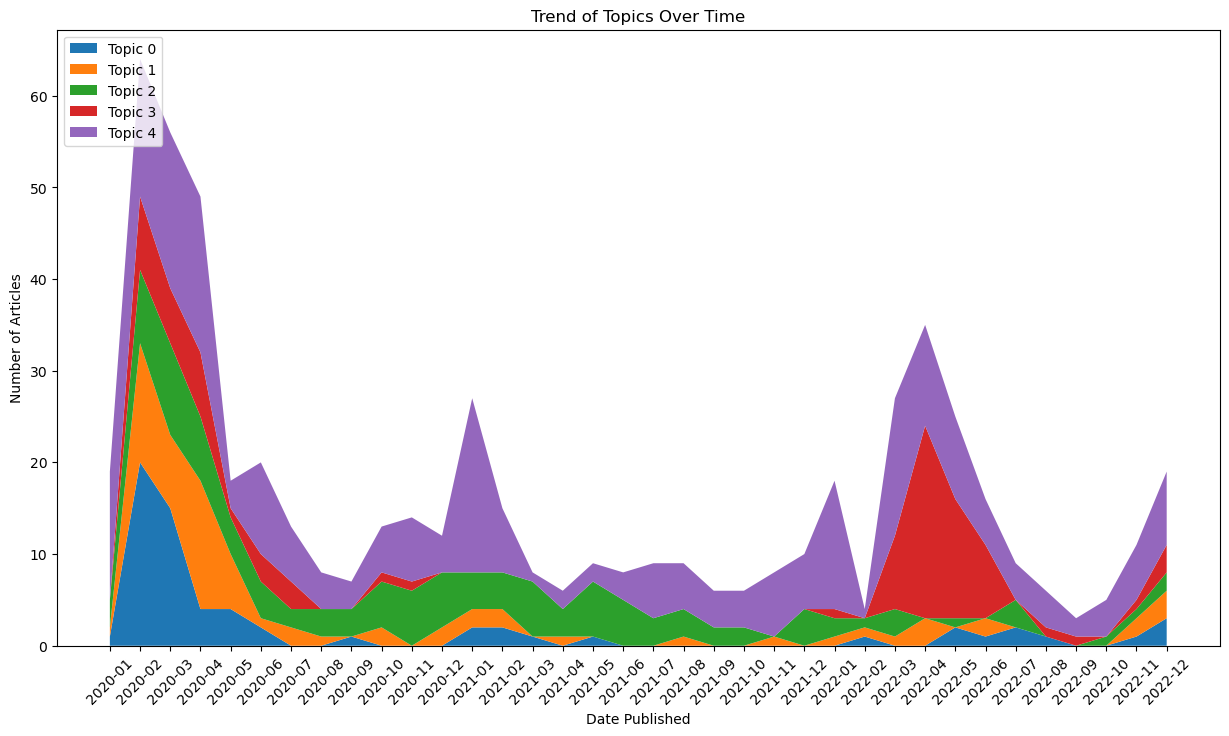

In [13]:
plt.figure(figsize=(15, 8))

# Create a stacked area plot where each area corresponds to a different topic
plt.stackplot(trend_analysis.columns.astype(str), trend_analysis.values, labels=['Topic {}'.format(i) for i in trend_analysis.index])

plt.title('Trend of Topics Over Time')
plt.xlabel('Date Published')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45) 
plt.legend(loc='upper left')

Analysis:  
Early in the pandemic, reporting was more focused on immediate responses and experiences, both from the public and within the healthcare system. As time progressed, the focus shifted to vaccine development and implementation, with periodic attention to specific measures such as lockdowns and mass testing. The trends correspond to the waves of COVID-19 cases and subsequent policy responses.   
- Topic 0: General public response and opinions in China  
The blue area is most prominent at the beginning of the timeline, suggesting that there was a significant amount of reporting on general public response and sentiment at the start of COVID-19, corresponding to the immediate societal shockwave sent by the initial outbreak.  
- Topic 1: Healthcare system and patient experiences  
The orange section also starts strong but decreases over time, indicating that there was a lot of coverage on hospitals and patient stories early on, aligning with the initial impact of COVID-19 on healthcare systems.  
- Topic 2: Vaccine Development and Health Policies  
The later rise of the green area, particularly noticeable around late 2020 and into early 2021, corresponds to the period of vaccine development and distribution, which would naturally peak after the initial outbreak reporting.  
- Topic 3: Lockdown in Shanghai  
The red area notably peaks in the first half of 2022, which coincides with the prolonged citywide lockdown measures in Shanghai.  
- Topic 4: City-level response and testing  
The purple area is dominant in several periods, suggesting sustained coverage of city-level response and mass testing measures. Notably, this coverage intensifies during colder months, aligning with periods of increased viral transmission with people traveling home for the traditional Spring Festival. Additionally, another peak is observed during the lockdown in Shanghai, reflecting the regular implementation of mass testing as a key strategy in containing the outbreak alongside the enforcement of lockdown measures.

### Relationship between dominant topics and article length

In [174]:
topics_df = pd.concat([df, df_topic_sents_keywords], axis=1)

# Drop duplicate columns after concatenation
topics_df = topics_df.T.drop_duplicates().T
# Ensure word_count column is treated as numerical values
topics_df['word_count'] = pd.to_numeric(topics_df['word_count'])

# Calculate statistics of word counts for articles within each dominant topic    
topics_df.groupby("Dominant_Topic")["word_count"].describe()

# Count refers to the number of articles associated with each topic. 
# Mean refers to the average word count of articles within each topic.

count         mean         std    min     25%     50%     75%  \
Dominant_Topic                                                                  
0                64.0  1002.562500  491.353326   89.0  647.00   960.0  1330.0   
1                70.0  1327.242857  924.995017  245.0  668.75  1122.5  1727.5   
2               117.0   684.777778  501.909322  205.0  365.00   483.0   846.0   
3                87.0   978.011494  761.648938   40.0  544.00   845.0  1294.0   
4               254.0   576.657480  344.849714   79.0  355.50   488.5   678.0   

                   max  
Dominant_Topic          
0               2524.0  
1               5435.0  
2               2578.0  
3               5224.0  
4               2667.0

<Axes: xlabel='word_count', ylabel='Dominant_Topic'>

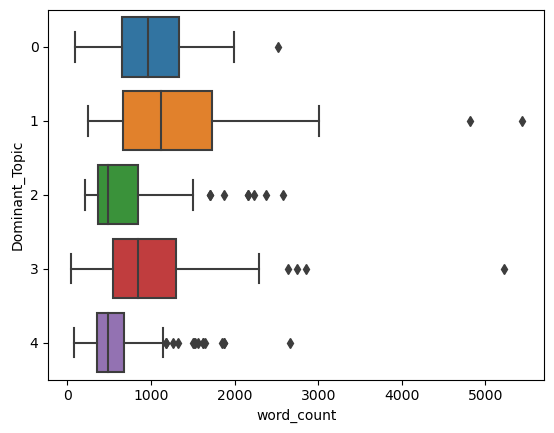

In [176]:
# Plotting
sns.boxplot(x='word_count', y='Dominant_Topic', data=topics_df, orient='h')

Analysis:  
As shown by article counts and word counts across different topics:  
- While there are more coverage of vaccine development and health policies (Topic 2) and city-level pandemic responses and mass testing (Topic 4), these articles tend to be more concise, potentially reflecting more straightforward reporting on these topics.  
- Although reports on public response (Topic 0), healthcare system and patient experiences (Topic 1), and lockdown in Shanghai (Topic 3) are less frequent, they occasionally result in longer articles, possibly related to comprehensive storytelling or in-depth elaboration on complex issues. 

## 3.4 Sentiment Analysis
This part uses Natural Language Processing techniques (reference to ChatGPT) to analyze the sentiment of articles, assessing the positive, negative, and neutral elements within. It investigates the temporal shifts in sentiment that may correspond to different phases of the pandemic, explores the variation in sentiment across various dominant topics, and finally, examines the relationship between the length of the articles and the degree of neutral sentiment across the main topics.

### Identify sentiment for the corpus and for each article¶ 

In [222]:
# Prepare for sentiment analysis

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
def get_sentiment(text):
    sentiment_dict = sia.polarity_scores(text)
    return sentiment_dict

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sixing/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [224]:
# Identify sentiment for the corpus

main_text = ' '.join(df['text'].dropna())
main_sentiment = get_sentiment(main_text)
print(f"Sentiment of main text: {main_sentiment}")

Sentiment of main text: {'neg': 0.077, 'neu': 0.841, 'pos': 0.082, 'compound': 1.0}


Analysis:  
- This result suggests that the text is predominantly neutral with very close amounts of positive and negative sentiment, which is typical for news reporting.

In [177]:
# Identify sentiment for each article

articles_sentiments = [get_sentiment(article) for article in articles]

sentiments_df = pd.DataFrame(articles_sentiments)
df = pd.concat([topics_df, sentiments_df], axis=1)
df.head()

title  \
0  As COVID Surges, Chinese Turn to Black Market ...   
1  China’s Inbound Travelers Confused Over Quaran...   
2  Staying Negative: New Covid Policies Bring Mem...   
3  Shanghai Races to Vaccinate Older Residents as...   
4  As Couriers Fall Sick, Chinese Cities Ask Resi...   

                                            subtitle date_published  \
0  Scalpers are reportedly selling Paxlovid for a...     2022-12-28   
1  Many returnees say they’re unsure about going ...     2022-12-23   
2  The Chinese internet has exploded with people ...     2022-12-23   
3  A district has started its fourth booster dose...     2022-12-21   
4  The delivery sector is facing an acute shortag...     2022-12-21   

                                                text  \
0  The lack of availability of a crucial COVID-19...   
1  Isabella Tang paid a hefty sum to return home ...   
2  Since China pivoted away from its “dynamic zer...   
3  SHANGHAI — Two days after Shanghai’s Jinshan D...   
4  Many Chinese cities are rallying local residen...   

                                     link year_month  year week_of_year  \
0  https://www.sixthtone.com/news/1011990    2022-12  2022           52   
1  https://www.sixthtone.com/news/1011970    2022-12  2022           51   
2  https://www.sixthtone.com/news/1011945    2022-12  2022           51   
3  https://www.sixthtone.com/news/1011952    2022-12  2022           51   
4  https://www.sixthtone.com/news/1011953    2022-12  2022           51   

   word_count Dominant_Topic Perc_Contribution  \
0         547              0            0.6708   
1         475              4            0.7905   
2         806              3            0.7789   
3         492              2            0.7146   
4         546              4            0.5987   

                                      Topic_Keywords    neg    neu    pos  \
0  china, people, say, one, wuhan, like, many, ci...  0.084  0.847  0.069   
1  say, city, test, china, case, people, local, a...  0.059  0.835  0.106   
2  say, shanghai, day, lockdown, people, resident...  0.065  0.772  0.163   
3  vaccine, china, say, health, chinese, country,...  0.064  0.868  0.068   
4  say, city, test, china, case, people, local, a...  0.087  0.811  0.103   

   compound  
0   -0.8658  
1    0.9819  
2    0.9982  
3    0.6053  
4    0.8601

### Trend analysis for sentiment over time

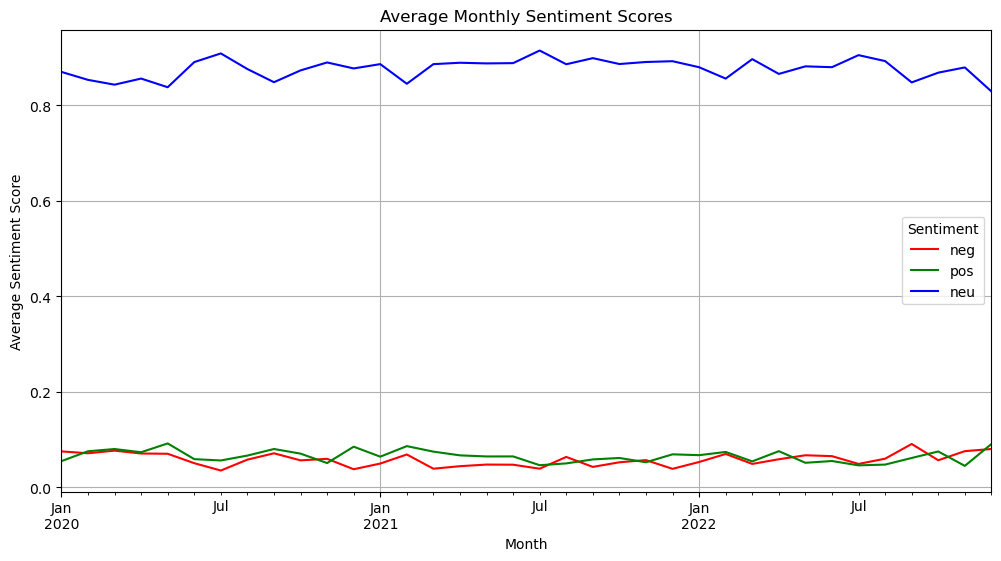

In [226]:
# Calculating monthly average sentiment
monthly_avg_sentiments = df.groupby('year_month')[['neg', 'pos', 'neu']].mean()

# Plotting
monthly_avg_sentiments.plot(
    figsize=(12, 6),
    color={'neg': 'red', 'pos': 'green', 'neu': 'blue'},
    title='Average Monthly Sentiment Scores'
)
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Sentiment')
plt.grid(True)

Analysis:  
In general, Sixth Tone's coverage of COVID-19 in China shows a consistent, neutral, and balanced approach to reporting without bias towards positive or negative sentiment.  
- Consistent neutral reporting:  
The prominance and relatively flatness of the blue line suggests that the reporting tone has remained predominantly neutral and stable over the period. This implies that Sixth Tone has upheld a fact-focused and objective reporting style, which is common practice in journalism.  
- Balance of positive and negative sentiment:  
The proximity of the positive (green line) and negative (red line) sentiment throughout the period suggests a balanced portrayal of both grave and hopeful aspects of the COVID-19 situation in China. This reflects unbiased reporting that shows both sides of the story, presenting a comprehensive narrative without sensationalizing the content.  
- Subtle fluctuations in sentiment:  
While the overall sentiment trends do not show significant fluctuations, there are slight variations over time, which might correlate with specific stages of the pandemic in China. For example, after China successfully contained the virus in early 2020, a prevailing positive sentiment underscores reports, suggestinga phase of optimism (green line above the red). However, the resurgence of infections and ensuing lockdowns from early 2022 appear to have given rise to an uptick in negative sentiment (red line overtaking the green), reflecting the reemergence of challenges and potentially criticisms of the pandemic's handling.

### Sentiment distribution across dominant topics

                     neg       neu       pos
Dominant_Topic                              
0               0.080562  0.832734  0.086672
1               0.077829  0.843371  0.078829
2               0.052000  0.872838  0.075154
3               0.060954  0.864460  0.074529
4               0.057433  0.887571  0.054984


Text(0.5, 1.0, 'Average Sentiment Scores for Each Dominant Topic')

<Figure size 1500x800 with 0 Axes>

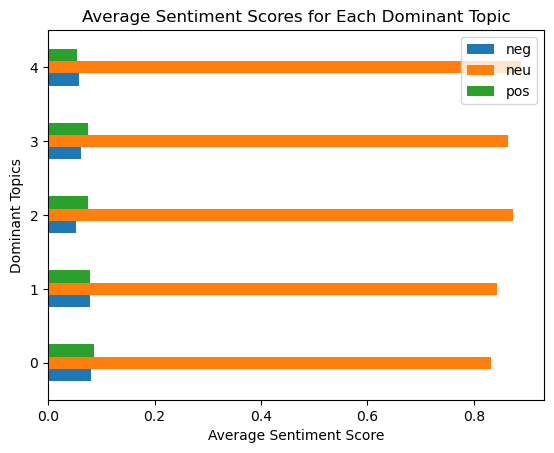

In [195]:
# Analyze negative, neutral, and positive sentiment across various main topics

avg_sentiment_per_topic = df.groupby('Dominant_Topic')[['neg', 'neu', 'pos']].mean()
print(avg_sentiment_per_topic)

# Plotting
plt.figure(figsize=(15, 8))
avg_sentiment_per_topic.plot.barh()
plt.xlabel('Average Sentiment Score')
plt.ylabel('Dominant Topics')
plt.title('Average Sentiment Scores for Each Dominant Topic')

Analysis:  
- Neutral sentiment across topics:  
For all topics, the neutral sentiment is the most prominent, indicating that the reports are primarily informative and objective across various aspects of the pandemic coverage.  
- Emotional public response:  
Topic 0 about general public response shows the highest variability in sentiment, with the most significant levels of both positive and negative sentiment. This suggests that articles on this topic might capture a wider range of public emotions, from concerns and frustrations to hope and solidarity, reflecting the emotionally charged nature of public discourse during the pandemic.  
- Optimistic tone in vaccine reporting:  
Topic 2 related to vaccine development has the lowest negative sentiment among all topics, suggesting a more optimistic and favorable representation of vaccine-related developments and outcomes.  
- Critical examination of cities' response:  
While articles of most topics show a marginally higher positive sentiment compared to negative sentiment, this is not the case for topic 4, which delves into city-level responses and mass testing. This suggests that the coverage of urban strategies towards the pandemic tend to hold a more critical tone, emphasizing the hurdles and complexities faced over positive outcomes or successes.

Text(0.5, 1.0, 'Neutral Sentiment Scores for Each Dominant Topic')

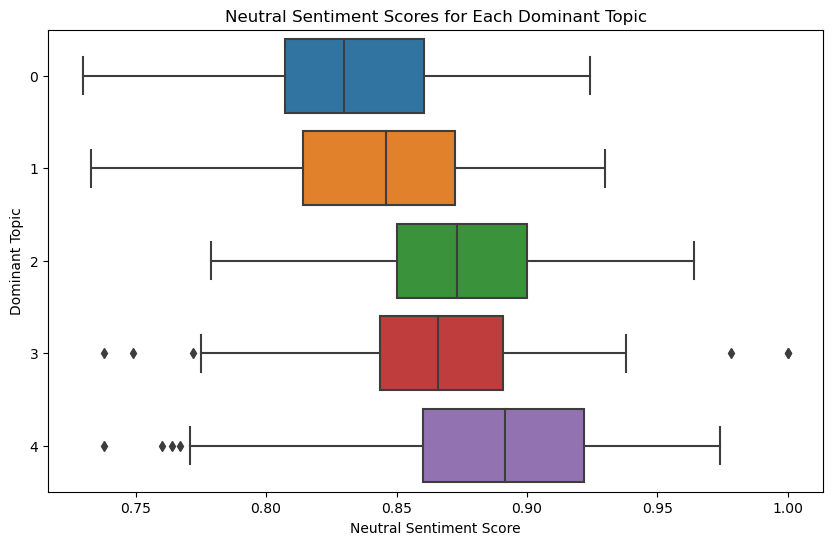

In [191]:
# Analyze neutral sentiment across various dominant topics

# Filter the DataFrame to only include neutral sentiment scores
df_neu = df[['Dominant_Topic', 'neu']]

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='neu', y='Dominant_Topic', data=df_neu, orient='h')
plt.xlabel('Neutral Sentiment Score')
plt.ylabel('Dominant Topic')
plt.title('Neutral Sentiment Scores for Each Dominant Topic')

Analysis:   
- Overall, the spread of neutral sentiment scores shows that articles on vaccine development (Topic 2) and city-level response and testing (Topic 4) generally show higher levels of neutrality. This tendency could be attributed to their focus on data-driven and fact-based updates about vaccine progress or testing results.  
- In contrast, articles about public response (Topic 0), patient experiences (Topic 1), and Shanghai’s lockdown (Topic 3) tend to be more subjective. This is likely influenced by the inclusion of human-interest elements, such as personal accounts and emotional narratives from individuals directly impacted by the pandemic, which inherently carry more subjective sentiments.  
- The presence of outliers, especially in articles about Shanghai’s lockdown (Topic 3) and city-level response and testing (Topic 4), indicates instances of significantly divergent neutral sentiment scores. These outliers could refer to certain articles that express more distinctly positive or negative sentiments within these topics.

### Relationship between article length and neutral sentiment across dominant topics

Correlation coefficient: -0.37451232147970837


Text(37.31382225028061, 0.5, 'Neutral Sentiment Score')

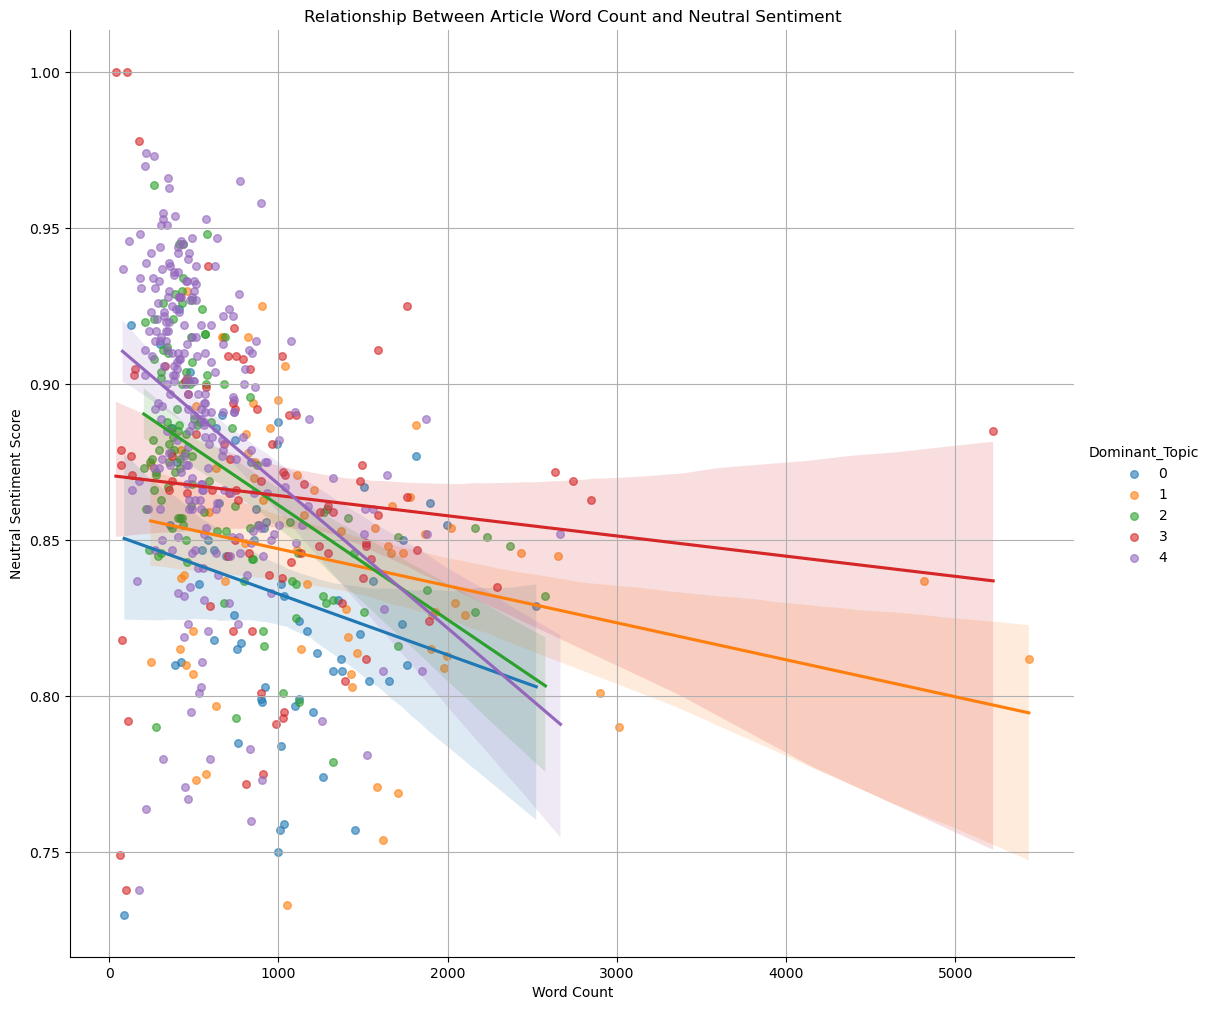

In [204]:
# Calculate the correlation coefficient of word counts and neutral sentiment
corr_coef = df['word_count'].corr(df['neu'])
print(f"Correlation coefficient: {corr_coef}")

# Set the opacity and size of the points in the plot for better readability 
scatter_kws = {"alpha": 0.6, "s": 30}
# Create a linear regression plot
sns.lmplot(x='word_count', y='neu', hue='Dominant_Topic', data=df,
           height=10, aspect=1.1,
           scatter_kws=scatter_kws)
plt.grid(True)
plt.title('Relationship Between Article Word Count and Neutral Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Neutral Sentiment Score')

Analysis:  
- Overall, the analysis shows a moderate negative correlation between the length of articles and their neutral sentiment, suggesting that longer pieces tend to show a decrease in neutrality. This trend is likely due to the inclusion of more emotive language, either positive or negative, from interviewees as the reports delve deeper into the complexities of the topics. In contrast, shorter articles tend to primarily focus on factual content, thus adhering more closely to a neutral tone.  
- Topic-specific trends:  
Articles about vaccine development (Topic 2) and city-level pandemic responses (Topic 4) show a sharper decline in neutral sentiment as the word count increases. This suggests that in-depth coverage in these fields tend to incorporate a higher degree of subjectivity. On the other hand, topics such as public response (Topic 0), patient experiences (Topic 1), and Shanghai’s lockdown (Topic 3) show a subtler correlation between article length and neutral sentiment, indicating a relatively consistent level of neutrality regardless of the article's length.  
This pattern could be attributed to the inherent nature of the topics: Topics 2 and 4, which often cover more factual, data-driven updates like vaccine progress and testing results, start from a more neutral baseline, making any shift in tone more noticeable as the articles get longer.